# NS3 - Camera Calibration and Object Tracking

This notebook will introduce you to object tracking and camera calibration.

This notebook is structured as follows:

1. Introduction and Definitions  
2. ICP (Iteractive Closest Point)  
3. Multiview Camera Setup (Calibration, Leaveraging Multi-View Images)  

## Important Note: Please download the additional assets from this link

- https://syncandshare.lrz.de/getlink/fiNisuRxdcMKkwAWrywo3ALb/NS3-Camera%20Calibration%20and%20Object%20Tracking 
- Password: pphau23



## 1 Introduction and Definitions 

#### Rigid Body Objects
We define rigid bodies or rigid objects as objects which do not deform,and change their shape. Therefore, we could define the position of each vertex (each angular point of a polygon, polyhedron, or other figure) using a 6DoF (6 degrees of freedom; translation and rotation) applied to the pivot of the object. Translation $t \in R^3$ and rotation $r \in SO(3)$.
#### 3D Object Representations
Object representation are the methods of representing the geometry of the object in addition to some other information like color, material properties, and so on.

* **Point Clouds:** Object is defined as a set of points in 3D (there is no actual definition of a surface here). We can assign properties like color, normal vectors to each vertex

* **Meshes:** Objects are defined as a list of vertices. The surfaces are then defined as the faces connecting these vertices. In addition to vertex properties we could assign properties to the faces.

* **Other Representations(Not covered here):** There are other ways to represent surfaces like SDF (Signed Distance Fields) which is a level-set method which defines the surface at signed distance values equal to 0 or implicit representations using neural networks (NERF: Neural Radiance Fields [2]). Each representation has advantages and disatvantages depending on the operation we want to apply to it. For example pointclouds/meshes are fast to evaluate points, or traversing the surface. However, SDFs are more efficient for collision detection. [1]

#### Object Scanning and Processing


In SS2 we shown objects scanned using Meshroom \[[4](https://alicevision.org/)\]. The final output of this software is a textured mesh that we could use for our own applications.
Note that textured meshes define color on the mesh using a UV map that will be projected to wrap the mesh surface. To simplify our setup, we could use Meshlab \[[3](https://www.meshlab.net/)\] to transfer the colors from textures to vertices, also we could apply other transformations and filters like scaling, moving the origin of the object,...etc.

Here we will use open3d \[[5](http://www.open3d.org/docs/release/)\] and show an example of pointcloud/mesh loading and manipulation.

In [2]:
## create a venv on top of the system packages
!python3 -m venv venv-ns3 –system-site-packages

In [5]:
!source venv-ns3/bin/activate

In [1]:
!pip install --force-reinstall open3d

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 420.5/420.5 MB 31.4 MB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 701.2/701.2 KB 30.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 28.8 MB/s eta 0:00:0031m28.9 MB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 29.0 MB/s eta 0:00:0031m29.0 MB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 KB 228.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 KB 30.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.3/138.3 KB 46.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 KB 250.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 28.7 MB/s eta 0:00:00 MB/s eta 0:00:01:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 29.2 MB/s eta 0:00:001m29.1 MB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 10.9 MB/s eta 0:00:00MB/

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.8/341.8 KB 34.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.0/298.0 KB 39.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.5/34.5 MB 32.8 MB/s eta 0:00:0031m33.2 MB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.1/133.1 KB 29.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.6/96.6 KB 40.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 282.1/282.1 KB 43.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 30.4 MB/s eta 0:00:0031m30.7 MB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 426.9/426.9 KB 26.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 27.3 MB/s eta 0:00:00 MB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 KB 71.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 32.8 MB/s eta 0:00:0031m34.3 MB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━

      Successfully uninstalled pickleshare-0.7.5
  Attempting uninstall: executing
    Found existing installation: executing 0.8.2
    Uninstalling executing-0.8.2:
      Successfully uninstalled executing-0.8.2
  Attempting uninstall: backcall
    Found existing installation: backcall 0.2.0
    Uninstalling backcall-0.2.0:
      Successfully uninstalled backcall-0.2.0
  Attempting uninstall: addict
    Found existing installation: addict 2.4.0
    Uninstalling addict-2.4.0:
      Successfully uninstalled addict-2.4.0
  Attempting uninstall: zipp
    Found existing installation: zipp 3.7.0
    Uninstalling zipp-3.7.0:
      Successfully uninstalled zipp-3.7.0
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.5.2
    Uninstalling widgetsnbextension-3.5.2:
      Successfully uninstalled widgetsnbextension-3.5.2
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.0.1
    Uninstalling typing_extensio

    Uninstalling joblib-1.1.0:
      Successfully uninstalled joblib-1.1.0
  Attempting uninstall: fonttools
    Found existing installation: fonttools 4.29.1
    Uninstalling fonttools-4.29.1:
      Successfully uninstalled fonttools-4.29.1
  Attempting uninstall: decorator
    Found existing installation: decorator 5.1.1
    Uninstalling decorator-5.1.1:
      Successfully uninstalled decorator-5.1.1
  Attempting uninstall: debugpy
    Found existing installation: debugpy 1.5.1
    Uninstalling debugpy-1.5.1:
      Successfully uninstalled debugpy-1.5.1
  Attempting uninstall: cycler
    Found existing installation: cycler 0.11.0
    Uninstalling cycler-0.11.0:
      Successfully uninstalled cycler-0.11.0
  Attempting uninstall: click
    Found existing installation: click 8.0.3
    Uninstalling click-8.0.3:
      Successfully uninstalled click-8.0.3
  Attempting uninstall: attrs
    Found existing installation: attrs 21.4.0
    Uninstalling attrs-21.4.0:
      Successfully uninstall

    Uninstalling open3d-0.15.2:
      Successfully uninstalled open3d-0.15.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipympl 0.9.1 requires ipywidgets<8,>=7.6.0, but you have ipywidgets 8.0.6 which is incompatible.


You should consider upgrading via the '/home/marsil/git/notebooks/venv/bin/python3 -m pip install --upgrade pip' command.


In [10]:
# required libraries
import open3d as o3d
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation
from sklearn.metrics import mean_squared_error

In [11]:
# load mesh from .ply or .obj file
# if you have a textured mesh (colors are defined using a uv map we should enable post processing enable_post_processing=True)
textured_mesh = o3d.io.read_triangle_mesh('assets/models/oats/texturedMesh_alligned.obj', enable_post_processing=True)
print(f" is textured? {textured_mesh.has_textures()}. has vertex colors? {textured_mesh.has_vertex_colors()}. num_vertices = {len(textured_mesh.vertices)}. num_faces(triangles) = {len(textured_mesh.triangles)}")
# visualize the data (blocking)
o3d.visualization.draw_geometries([textured_mesh])

 is textured? True. has vertex colors? False. num_vertices = 378833. num_faces(triangles) = 688606


In [12]:
mesh = o3d.io.read_triangle_mesh('assets/models/oats/texturedMesh_alligned_vertex_color.ply')
print(f" is textured? {mesh.has_textures()}. has vertex colors? {mesh.has_vertex_colors()}. num_vertices = {len(mesh.vertices)}. num_faces(triangles) = {len(mesh.triangles)}")
object_transform = np.eye(4)
object_transform[:3,:3] = Rotation.from_euler('xyz',[45,0,90], degrees=True).as_matrix()
object_transform[:3, 3] = [1,2,4]
# add axis coordinate frame (xyz - rgb)
mesh_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.5, origin=[0,0,0])
mesh.transform(object_transform)
mesh_frame.transform(object_transform)

# visualize the data (blocking)
o3d.visualization.draw_geometries([mesh, mesh_frame])

 is textured? False. has vertex colors? True. num_vertices = 344438. num_faces(triangles) = 688606


In [13]:
# Processing point clouds
pcd = o3d.io.read_point_cloud('assets/models/oats/texturedMesh_alligned_vertex_color.ply')
'''
# To convert from a trimesh:  (if you have a textured meshmake sure to transfer texture color to vertex color using Meshlab filters)
assert mesh.has_vertex_colors
pcd = o3d.geometry.PointCloud()
pcd.points=mesh.vertices
pcd.colors=mesh.vertex_colors
'''
voxel_down_sampled_pcd = o3d.geometry.PointCloud(pcd).voxel_down_sample(voxel_size=0.001).translate([1,0,0])
print(f"voxel_down_sampling: num points before downsampleing is {len(pcd.points)}, after is {len(voxel_down_sampled_pcd.points)}")

uniform_down_sampled_pcd = o3d.geometry.PointCloud(pcd).uniform_down_sample(every_k_points=10).translate([2,0,0])
print(f"num points before downsampleing is {len(pcd.points)}, after is {len(uniform_down_sampled_pcd.points)}")


scaled_pcd = o3d.geometry.PointCloud(pcd).scale(0.4, pcd.get_center()).translate([3,0,0])

o3d.visualization.draw_geometries([pcd, voxel_down_sampled_pcd, uniform_down_sampled_pcd, scaled_pcd])

voxel_down_sampling: num points before downsampleing is 344438, after is 344073
num points before downsampleing is 344438, after is 34444


# 2 ICP (Iterative Closest Point)

Iterative Closest Point is an algorithm that locally aligns two 3D objects. Locally means there is already a rough global pose estimation for the two objects, and the ICP will try to find a small transformation between the 2 objects such that the objects alignment is more refined.   

Since, we use depth sensors as the main sensors for this course, we also have access to depth data for every frame, and as a result, an oriented pointcloud from aligned depth and color images. Therefore, we could use Iterative Closest Point (ICP) algorithm. ICP algorithm would allow us to utilize depth information to align pointcloud. 



### Steps:
#### Initial conditions:
We assume that we have 2 point clouds $P_{source}$ and $Q_{target}$. We want to register the source to the target by finding a rigid body transformation $T = [R|t]$ from source to target. We assume that the rotation and translation between the the two pointclouds is small.

#### Matching
Every iteration, we find a set of $m$ correpondences ${(u_1,v_1), (u_2,v_2), ..., (u_m,v_m)}$ where $p_{u_i} \in P_{source}$ and $q_{v_i} \in Q_{target}$. 
The matches are selected based on some criterion. The simplest is to match based on the closest distance. Additionally, we could ignore outliers where the distance closest point distance is larger than a given threshold. 

We define the list of points $P_{source}^{inliers} = \{p_{u_1}, ..., p_{u_m}\}$ and $Q_{target}^{inliers} = \{q_{v_1}, ..., q_{v_m}\}$ 

#### Transformation estimation loss minimization
Our goal is to find 

$$T^* = argmin_{T} || Q_{target}^{inliers} - P_{source}^{inliers} \times T  ||_2^2,$$

where $T = [R|t]$. Since $R \in SO(3)$ we need a constrained optimization scheme to guarantee that $R$ is a valid rotation matrix (or a valid rotation representation in general Quaternion, AxisAngle, etc.). Finding $t$ is simple once R is calculated.

For more technichal details you could check \[[6](http://graphics.stanford.edu/courses/cs468-10-fall/LectureSlides/03_Surface_Reconstruction.pdf)\]

#### Evaluation metrics
Visually we can visualize the transformed source point cloud and target to assess the quality of the result. 
But if we want to use a metric to evaluate the quality of the solution $T$ quantitatively, we have the following metrics that we can use:

* Inlier RMSE root mean squared error for the correspondences (the lower the better) $RMSE_{inlier} =  \sqrt{\frac{|| Q_{target}^{inliers} - P_{source}^{inliers} \times T  ||_2^2}{m}}$  
 
 
* $Fitness = \frac{m}{|Q_{target}|}$ (the higher the better) 

### Variations:

#### Point to Point ICP
The approach we followed above is a point to point ICP. $$T^* = argmin_{T} || Q_{target}^{inliers} - P_{source}^{inliers} \times T  ||_2^2$$
#### Point to Plane ICP
The minimization objective here aims to push points the surface plane of the target point cloud, by minimizing the source point to target plane distance.
This is done using the target point cloud normal vectors. $p_{u_i}$ belongs to the plane around 
$q_{v_i}$ if the dot product $(R \times p_{u_i} + t - q_{v_i})n_{v_i} = 0$

$$N_{targe}^{inliers} = \{ \vec n_{v1},...,n_{v_m} \}$$

$$T^* = argmin_{T} || (Q_{target}^{inliers} - P_{source}^{inliers} \times T) \times N_{target}^{inliers}  ||_2^2$$



For more details you could check \[[5](http://www.open3d.org/docs/release/)\],\[[6](http://graphics.stanford.edu/courses/cs468-10-fall/LectureSlides/03_Surface_Reconstruction.pdf)\] or [link](http://www.open3d.org/docs/latest/tutorial/t_pipelines/t_icp_registration.html)

/tmp/ipykernel_1014964/1644397563.py:5: DeprecationWarning: Please use `Rotation` from the `scipy.spatial.transform` namespace, the `scipy.spatial.transform.rotation` namespace is deprecated.
  from scipy.spatial.transform.rotation import Rotation


[0.77433877 0.78793649 1.50860303]
Iteration registration errors: Inlier MSE is 0.043176383156540155, Inlier Fitness is 0.26397975826506503
RMSE(same object) = 0.19948505394046923
cumulative translation = [0.00054199 0.01852425 0.00673761] cumulative rotation = [-0.89804054 -0.02515301  0.09150917]
Iteration registration errors: Inlier MSE is 0.041121751249822064, Inlier Fitness is 0.30274540933079486
RMSE(same object) = 0.1982178458748952
cumulative translation = [0.00104507 0.05382027 0.01899672] cumulative rotation = [-2.47771774 -0.08908557  0.28080563]
Iteration registration errors: Inlier MSE is 0.03829056684229968, Inlier Fitness is 0.3442707332047553
RMSE(same object) = 0.19540547651839069
cumulative translation = [0.00066772 0.10017058 0.03452181] cumulative rotation = [-4.31189848 -0.20366529  0.55579727]
Iteration registration errors: Inlier MSE is 0.037582216110884116, Inlier Fitness is 0.38756968949029774
RMSE(same object) = 0.19097134092056256
cumulative translation = [-0

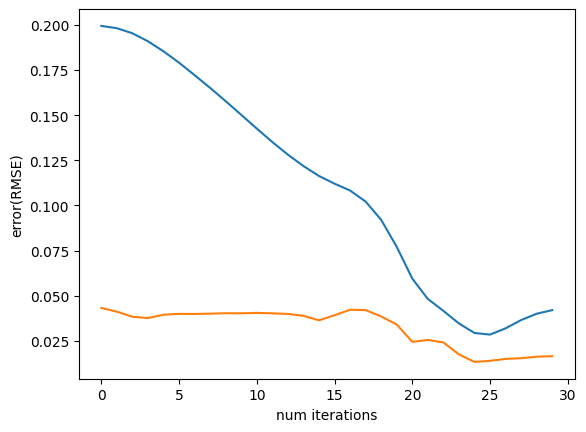

In [14]:
import open3d as o3d
import numpy as np
import cv2
from sklearn.metrics import mean_squared_error
from scipy.spatial.transform.rotation import Rotation
# read source point cloud
pcd_source = o3d.io.read_point_cloud('assets/models/oats/texturedMesh_alligned_vertex_color.ply')
pcd_source = pcd_source.voxel_down_sample(0.005)
# visualize the source point cloud
o3d.visualization.draw_geometries([pcd_source])
# create a mock target point cloud as a toy example
points = np.array(pcd_source.points)
extents = points.max(axis=0) - points.min(axis=0)
print(extents)
translation = 0.05 * extents
transform = np.eye(4)
transform[:3,3] = translation
pcd_target = o3d.geometry.PointCloud(pcd_source)
transform[:3,:3] = Rotation.from_euler('xyz', [25,0,0], degrees=True).as_matrix()
transform[:3,3] = [0,0,0.1]
pcd_target.transform(transform)

# set color for source to red and target to blue (later solution is green)
pcd_source.paint_uniform_color([1,0,0])
pcd_target.paint_uniform_color([0,1,0])

o3d.visualization.draw_geometries([pcd_source, pcd_target])

# Note it is better to run iCP once with ICPConvergenceCriteria(max_iteration=num_iteration) but here we want to visualize each step.
num_iterations = 30
initial_transformation = np.eye(4)
threshold = 0.05 * max(extents)
vis = o3d.visualization.Visualizer()
vis.create_window()
ctr = vis.get_view_control()
ctr.set_lookat([0, 0, 0])
pcd_solution = o3d.geometry.PointCloud(pcd_source)
pcd_solution.paint_uniform_color([0,0,1])
geometries = [pcd_source, pcd_target, pcd_solution]
o3d.visualization.draw_geometries(geometries)
cumulative_transformation = np.eye(4)
errors = []
errors2 = []
for iteration in range(num_iterations):
    reg_p2p = o3d.pipelines.registration.registration_icp(
                    pcd_solution, pcd_target, threshold, initial_transformation,
                o3d.pipelines.registration.TransformationEstimationPointToPoint(),
                o3d.pipelines.registration.ICPConvergenceCriteria(max_iteration=1),)
    
    solution_transform = reg_p2p.transformation
    cumulative_transformation = cumulative_transformation @ solution_transform
    diff = (np.array(pcd_solution.points) - np.array(pcd_target.points))
    # exact_rmse = np.mean(np.sum(diff ** 2, axis=1)**0.5)
    exact_rmse = mean_squared_error(np.array(pcd_solution.points), np.array(pcd_target.points), squared=False)
    errors.append(exact_rmse) # calculation could be slightly different from rmse in open3d
    errors2.append(reg_p2p.inlier_rmse)
    print(f"Iteration registration errors: Inlier MSE is {reg_p2p.inlier_rmse}, Inlier Fitness is {reg_p2p.fitness}")
    print(f"RMSE(same object) = {exact_rmse}")
    print(f"cumulative translation = {cumulative_transformation[:3,3]} cumulative rotation = {Rotation.from_matrix(cumulative_transformation[:3,:3]).as_euler('xyz', degrees=True)}")
    initial_transformation = solution_transform
    pcd_solution = pcd_solution.transform(solution_transform)
    if iteration%5 == 0:
        o3d.visualization.draw_geometries(geometries)


plt.plot(np.arange(num_iterations), errors)
plt.plot(np.arange(num_iterations), errors2)

plt.xlabel('num iterations')
plt.ylabel('error(RMSE)');

# 3 Multiview Camera Setup (Calibration, Leaveraging Multi-View Images)  
### Motivation

In a simplified setup where we deal only with rigid body objects, hand-object interactions are subject to different types of occlusions: hand-hand occlusion, self-occlusion, and hand-object occlusion. These types of occlusions increase the difficulty of the detection and pose estimation tasks.

Multiple approaches exist to overcome this issue. One of them is data-driven statistical priors, where a machine learning model learns to hallucinate the occluded parts of the interaction object or hand keypoints.

Another solution is to record data in multiple views and fuse them into one world coordinate system. In this case it is required to estimate the relative camera pose with respect to the real-world coordinate system. 
Note: Usually, the origin of the real-world coordinate system is defined either as the location of one of the cameras or defined with respect to each of them, for example, the center of the table in the tabletop setup. In general, if we have $K$ views, we need $K$ rigid body transformation matrices. Calculation of these rigid body transformation matrices in a multiple camera setup is the **multiview camera calibration**.

We have learned in the first lecture about the camera intrinsics and stereo extrinsics. In this lecture, we will focus on camera-camera extrinsics.  

### Calibration Process
In our setup we will use the tools provided by opencv to calibrate different views using a checkerboard.

In HW1 we used PnP to estimate the checkerboard pose and track the moving board over frames. During calibration the opposite is assumed, we have a stationary board and cameras from different views that have the board in their field of view.

We could use `cv2.calibrateCamera` or `cv2.solvePnP` (does not use RANSAC) along with the checkerboard pattern to calibrate multiple views.

* Note that in the more general case we could estimate the distortion polynomial ceffecients $D$ and intrinsics $K$.

Our goal is to minimize the reprojection error which is mean squared error between 2D correspondences and the perspective projection of the 3D correspondences.

### Leaveraging different views
Using different image views from the camera movement (ego-perspective) or multiple cameras could be usefull for multiple applications we will go through some of them here.

#### Multi-View Point Clouds
we can align and merge different point clouds coming from different depth images based on the calibration information.
check 
* `scripts/multiview.py` takes a calibration sequence, runs the calibration using PnP and visualize aligned point cloud.
* `scripts/visualize_o3d.py` takes a recordings bag file and a calibration file and visualize the aligned pointcloud.

#### Finding Correspondences (SIFT points) 
How to find correspondences between two <b>similar</b> images for the same object from slightly different camera angles. 
We could extract SIFT feature points and match the keypoints in images based on descriptors similarity.

#### Homography (Application for SIFT points)
Given two images $I_1, I_2$ for a textured planar surface (for example, a chessboard, or a table surface with a pattern on it). 
Define each plane on the surface by a set of feature points $P_1, P_2$.
Homography is a structure perserving transformation (In our case we are interested in finding 6DoF rigid body transformation) as this will correspond to the relative  transformation between two camera poses.

In [16]:
# https://docs.opencv.org/3.4/d1/de0/tutorial_py_feature_homography.html
import numpy as np
import cv2
from matplotlib import pyplot as plt
MIN_MATCH_COUNT = 10
img1 = cv2.imread('assets/image1.png',0)          # queryImage
img2 = cv2.imread('assets/image2.png',0)          # trainImage
# Initiate SIFT detector
sift = cv2.SIFT_create()
# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)
flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1,des2,k=2)
# store all the good matches as per Lowe's ratio test.
good = []
for m,n in matches:
    if m.distance < 0.7*n.distance:
        good.append(m)

In [17]:
if len(good)>MIN_MATCH_COUNT:
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
    matchesMask = mask.ravel().tolist()
    h,w = img1.shape
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv2.perspectiveTransform(pts,M)
    img2 = cv2.polylines(img2,[np.int32(dst)],True,255,3, cv2.LINE_AA)
else:
    print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )
    matchesMask = None


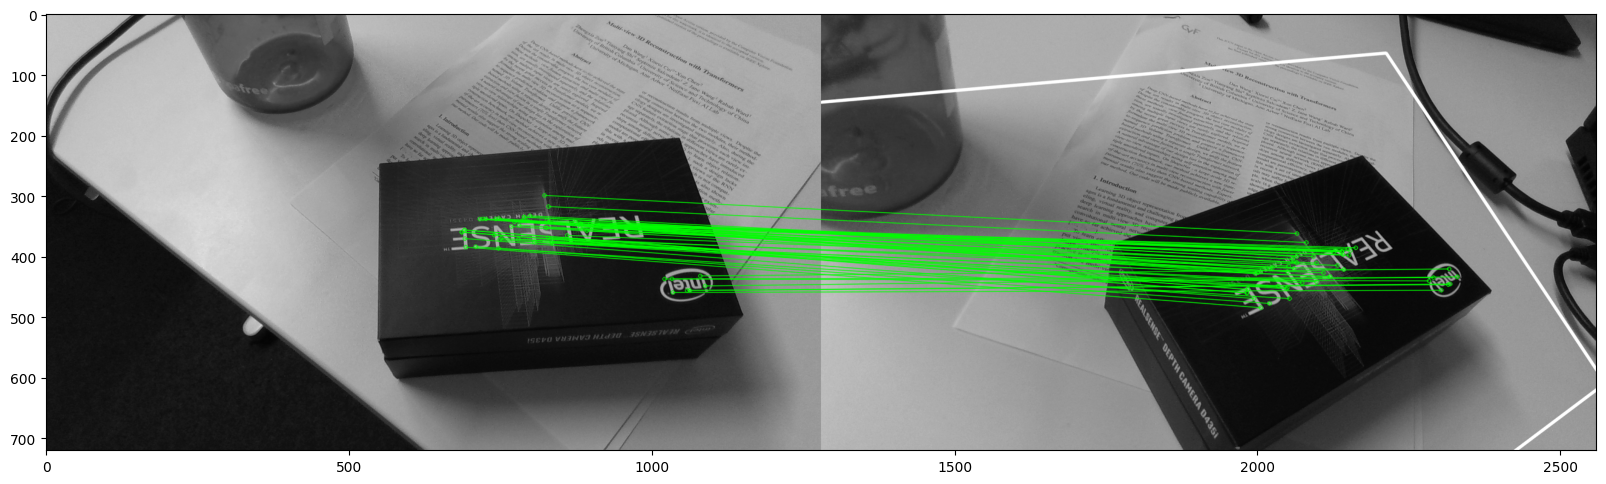

In [18]:
draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None,
               
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)
img3 = cv2.drawMatches(img1,kp1,img2,kp2,good,None,**draw_params)
fig=plt.figure(figsize=(20,20))
plt.imshow(img3, 'gray');

#### RANSAC (RANdom SAmple Consensus)


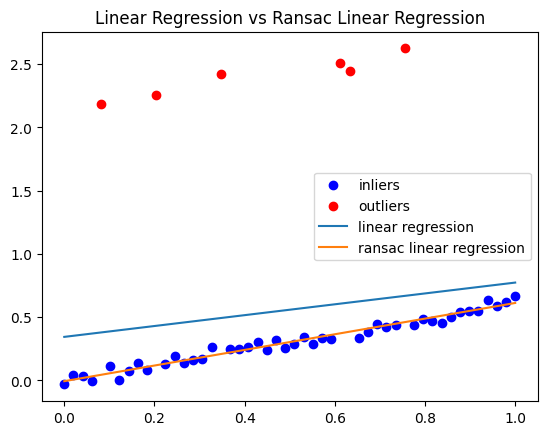

In [19]:
import sklearn.linear_model as linear_model
np.random.seed(123)
# generate points    
num_points = 50
alpha = 0.6
beta = np.random.normal(0.0, 0.03, size=(num_points,1))


X = np.linspace(0, 1.0, num_points).reshape(num_points,1)
Y = alpha * X + beta

# randomly create outliers
inlier_ratio = 0.8
outlier_ratio = 1-inlier_ratio

inlier_mask = np.random.choice([True, False], size=(num_points,), p=[inlier_ratio, outlier_ratio])
outlier_mask = ~inlier_mask
Y[outlier_mask] += np.random.normal(1,1)

plt.scatter(X[inlier_mask],Y[inlier_mask], color='blue', label='inliers')
plt.scatter(X[outlier_mask],Y[outlier_mask], color='red', label='outliers')
# print(X.shape, Y.shape)
linear_regression = linear_model.LinearRegression()
linear_regression.fit(X , Y)
# print(X.shape, linear_regression.coef_.shape, linear_regression.intercept_.shape)
plt.plot(X, linear_regression.predict(X), label="linear regression")

ransac_linear_regression = linear_model.RANSACRegressor()
ransac_linear_regression.fit(X, Y)

plt.plot(X, ransac_linear_regression.predict(X), label="ransac linear regression")

plt.legend()
plt.title('Linear Regression vs Ransac Linear Regression');

####  Perspective N – points problem (PnP)
* We already used PnP in HW1 for object tracking. Here we will have an overview on its usage with Ransac
* Given $N$ 3D points in the world coordinate system $P_w \in \mathbb{R}^{N \times 3}$.
* You are given 2 different views with a calibrated camera intrinsics $K\in \mathbb{R}^{3 \times 3}$ with the 2D pixel correspondence of the previous $N$ points $p_{c}, p_{c} \in \mathbb{R}^{N \times 2}$
* Find the relative rotation and translation between the two camera views $[R|t] \in \mathbb{R}^{4x3}$.
* The perpective projection is formulated as follows using homogeneous coordinates
$$\overline{p_c} = K \times [R|t] \times \overline{P_w}$$
$$ \overline{P_w} = (x_{P_w}, y_{P_w}, z_{p_w}, 1)^T$$
$$ p_c = (u, v) = \frac{X_{p_c}} {Z_{p_c}} , \frac{Y_{p_c}}{Z_{p_c}} $$ 
* We could use RANSAC to have a more robust estimation using `cv2.solvePnPRansac`.

# Homework (ICP Tracker)
* Workload: 4 students
* Deadline: due in 1 week
* Goal: Apply ICP between a point cloud from a scanned model (source) and a a point cloud from realsense recording (ros wrapper bag).  

### Task 1: Loading the model 
**1.1** Load the point cloud for the oats can using `open3d`  
**1.2** Downsample the pointcloud using voxel downsampling (set voxel size to 0.01).  

Resulting output should look like the image below:

<br>
<img src="assets/homework/images/downsampled_pcd.png" width=300 title="Downsampled Model Pointcloud" />

### Task 2: Loading the realsense sequence
**2.1** Read the color, depth, and camera info topics from the rosbag using `pyrosbag` library. It is enough to use the first 50 color and first depth frames.  
**2.2** Use `o3d.geometry.PointCloud.create_from_rgbd_image` to create a point cloud

Resulting output should look like the image below:

<br>
<img src="assets/homework/images/realsense_pcd.png" width=300 title="Realsense Point Cloud" />

### Task 3: Pose Initialization

**3.1** Use `o3d.visualization.VisualizerWithEditing` following the [tutorial](http://www.open3d.org/docs/latest/tutorial/visualization/interactive_visualization.html?highlight=visualizerwithediting) to get correspondences between the realsense pointcloud and the oats can model pointcloud.  
**3.2** Find a rigid body transformation and scale for the initial pose using `open3d.pipelines.registration.TransformationEstimationPointToPoint`

<br>

<img src="assets/homework/images/oats_correspondences.png" title="Picking Model Correspondences" width=200 /> 

<br>

<img src="assets/homework/images/realsense_correspondences.png" title="Realsense Correspondences" width=200 />

<br>

**3.3** Align the model pointcloud to the realsense pointcloud, and visualize the alignment.

<br>

<img src="assets/homework/images/model_pcd_allignemtn.png" title="Aligned Output" />
    
### Task 4: Pose Tracking

**4.1** Iterate over the color and depth frames each timestep and run ICP to refine the previous model pose (use the previous pose as initial pose).  
**4.2** Visualize the change overtime (you could reuse the source code in this notebook to help you visualize the data.

<br>

<img src="assets/homework/images/icp_after_first_few_iterations.png" width=300 title="ICP Tracking After Few Iterations (Color)"/>

<br>

<img src="assets/homework/images/icp_after_first_few_iterations_diff.png" width=300 title="ICP Tracking After Few Iterations (Change)"/>

<br>

**4.3** Plot or print the inlier RMSE and fitness overtime.

## References:

[1]. http://graphics.stanford.edu/courses/cs468-10-fall/LectureSlides/04_Surface_Reconstruction.pdf

[2]. https://www.matthewtancik.com/nerf

[3]. https://www.meshlab.net/

[4]. https://alicevision.org/

[5]. http://www.open3d.org/docs/release/

[6]. http://graphics.stanford.edu/courses/cs468-10-fall/LectureSlides/03_Surface_Reconstruction.pdf

[7].https://docs.opencv.org/4.4.0/d9/d0c/group__calib3d.html

[8]. https://www.youtube.com/watch?v=tcJHnHpwCXk